In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
import seaborn as sns
current_palette = sns.color_palette("hls", 8)
sns.set_palette(current_palette)
from mpl_toolkits.basemap import Basemap

import plotly.plotly as py
import plotly.graph_objs as go

from ipywidgets import *

In [3]:
import rpy2.robjects as robjs
from rpy2.robjects.packages import importr
import statsmodels.api as sm
from IPython.display import display
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
# Import R packages in Python
r = robjs.r
nlme = importr('nlme')
stats = importr('stats')
gstat = importr('gstat')  # Create symlink from anaconda envs tcl to ./lib/tcl
sp = importr('sp')

In [49]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")

In [50]:
set_style()

In [14]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

# View data
print(nc)

<xarray.Dataset>
Dimensions:        (latitude: 240, longitude: 1440, time: 1968)
Coordinates:
  * latitude       (latitude) float32 89.875 89.625 89.375 89.125 88.875 ...
  * longitude      (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 ...
  * time           (time) datetime64[ns] 1850-01-15 1850-02-15 1850-03-15 ...
Data variables:
    seaice_conc    (time, latitude, longitude) float32 99.2614 99.2614 ...
    seaice_source  (time, latitude, longitude) float32 21.0 21.0 21.0 21.0 ...
Attributes:
    CDI:                       Climate Data Interface version 1.6.2 (http://c...
    Conventions:               CF-1.4
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.6.2 (http://c...
    NCO:                       4.4.2
    version:                   1.0
    release_date:              December_30,_2015
    history:                   Updated G10010_SIBT1850.nc; Enforced consisten...
    filename:                  G10010_SIBT1850_v1.01i


In [15]:
# View seaice concentration
nc.seaice_conc

<xarray.DataArray 'seaice_conc' (time: 1968, latitude: 240, longitude: 1440)>
[680140800 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.875 89.625 89.375 89.125 88.875 88.625 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * time       (time) datetime64[ns] 1850-01-15 1850-02-15 1850-03-15 ...
Attributes:
    short_name:     concentration
    long_name:      Sea_Ice_Concentration
    standard_name:  Sea_Ice_Concentration
    units:          Percent

In [16]:
# See what dates we have
nc.time

<xarray.DataArray 'time' (time: 1968)>
array(['1850-01-15T00:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-15T00:00:00.000000000', ..., '2013-10-15T00:00:00.000000000',
       '2013-11-15T00:00:00.000000000', '2013-12-15T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-15 1850-02-15 1850-03-15 ...
Attributes:
    standard_name:  time

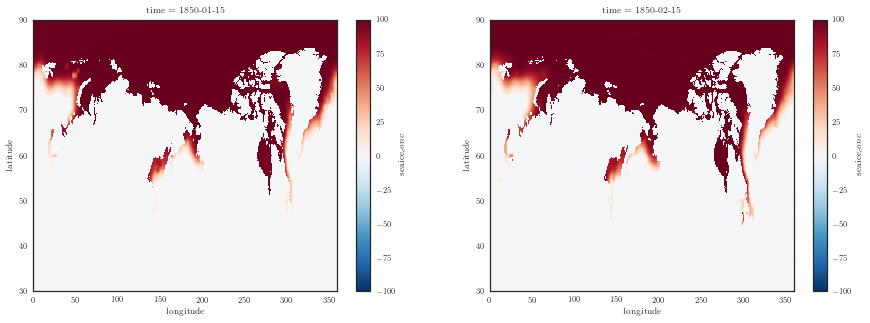

In [17]:
# Take a look at seaice_conc by plotting
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
nc.seaice_conc[0].plot(ax=ax1)
nc.seaice_conc[1].plot(ax=ax2)

In [18]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

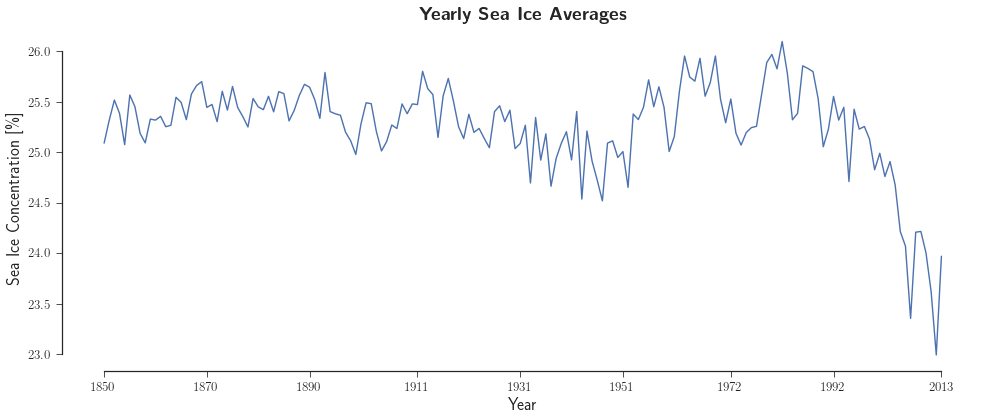

In [61]:
f, ax = plt.subplots(1, 1, figsize=(14,6))
sns.set_style("ticks")
ax.plot(yr_avg.year.values, yr_avg.values)
ax.set_title(r'\textbf{Yearly Sea Ice Averages}', fontsize=19)
ax.set_ylabel(r'Sea Ice Concentration [\%]', fontsize=17)
ax.set_xlabel(r'Year', fontsize=17)
ax.set_xticks(np.linspace(1850, 2013, 9, dtype=int))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.despine(trim=True)
f.tight_layout()
#f.savefig('writeup/figs/yrly_avgs.eps', format='eps', 
#          dpi=1200, bbox_inches='tight')

In [11]:
yr = go.Scatter(
    x = yr_avg.year.values,
    y = yr_avg.values,
    name = 'Yearly Seaice Conc',
    opacity = 0.8)

data = [yr]

layout = dict(
    title='Yearly Seaice Averages',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label='5yr',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10yr',
                     step='year',
                     stepmode='backward'),
                dict(count=25,
                     label='25yr',
                     step='year',
                     stepmode='backward'),
                dict(count=50,
                     label='50yr',
                     step='year',
                     stepmode='backward'),
                dict(count=100,
                     label='100yr',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

In [12]:
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Yearly Seaice Averages")

## Regression model

Here we will use rpy2 to fit the common linear regression model with respect to time.
The goal is to see if there is a trend in yearly average seaice concentration.

In [13]:
y = yr_avg.values
t1 = yr_avg.year.values

In [14]:
robjs.globalenv['y'] = robjs.FloatVector(y)
robjs.globalenv['t1'] = robjs.FloatVector(t1)
fit = r.lm('y ~ t1')
print(str(r.summary(fit))[str(r.summary(fit)).find('Residuals:'):])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.99912 -0.17707  0.00519  0.20418  1.00251 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 31.7106483  1.3827229  22.933  < 2e-16 ***
t1          -0.0033389  0.0007157  -4.665 6.41e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4339 on 162 degrees of freedom
Multiple R-squared:  0.1184,	Adjusted R-squared:  0.113 
F-statistic: 21.77 on 1 and 162 DF,  p-value: 6.412e-06




**Looks like a strong evidence**

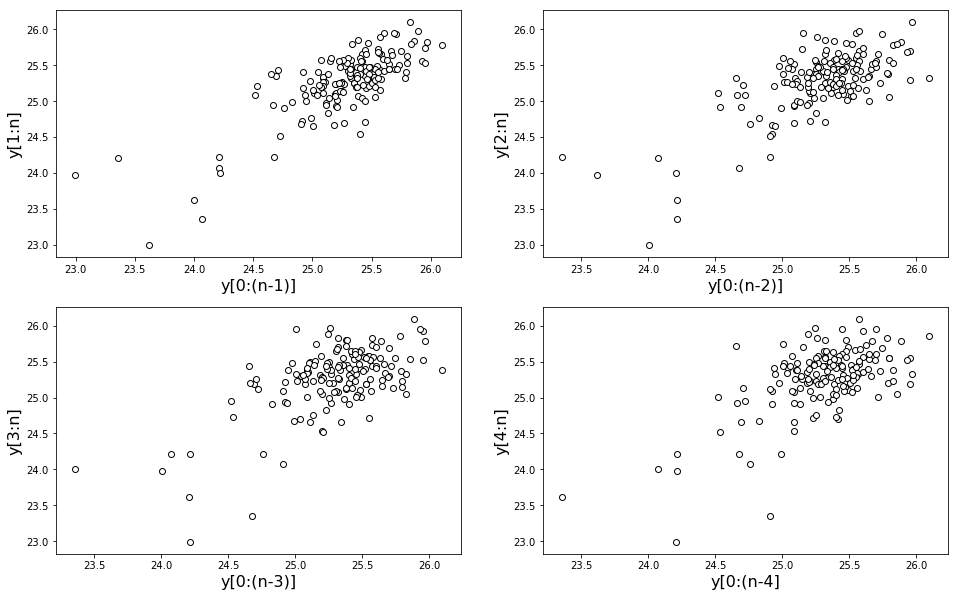

In [15]:
fig, ax = plt.subplots(2,2,figsize=(16,10))            # Set up figure and subplots
ax[0,0].scatter(y[:-1],y[1:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 1
ax[0,0].set_xlabel('y[0:(n-1)]',fontsize=16)            # x axis label
ax[0,0].set_ylabel('y[1:n]',fontsize=16)                # y axis label
ax[0,1].scatter(y[:-2],y[2:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 2
ax[0,1].set_xlabel('y[0:(n-2)]',fontsize=16)            # x axis label
ax[0,1].set_ylabel('y[2:n]',fontsize=16)                # y axis label
ax[1,0].scatter(y[:-3],y[3:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 3
ax[1,0].set_xlabel('y[0:(n-3)]',fontsize=16)            # x axis label
ax[1,0].set_ylabel('y[3:n]',fontsize=16)                # y axis label
ax[1,1].scatter(y[:-4],y[4:],edgecolor='k',facecolor='w')      # scatter plot of values shifted by 4
ax[1,1].set_xlabel('y[0:(n-4]',fontsize=16)            # x axis label
ax[1,1].set_ylabel('y[4:n]',fontsize=16)                # y axis label
plt.show()

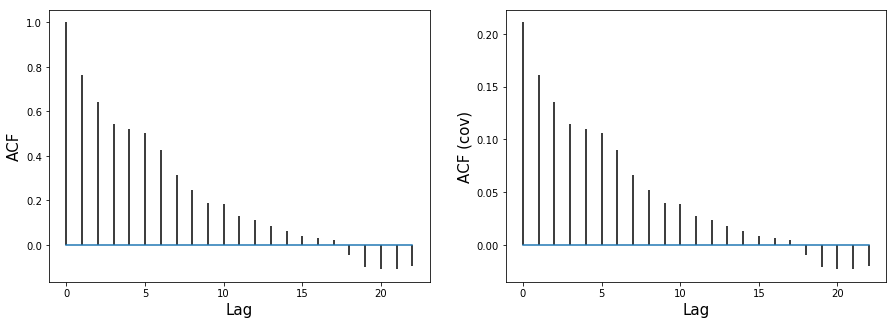

In [23]:
fig, ax = plt.subplots(1,2,figsize=(15,5))            # Set up figure and subplots
acf_corr = np.squeeze(np.array(stats.acf(robjs.FloatVector(y), ci=0, main='', type='correlation')[0]))
acf_cov = np.squeeze(np.array(stats.acf(robjs.FloatVector(y), ci=0, main='', type='covariance')[0]))
n = len(acf_corr) #number of lags
#-0 Plot Autocorrelation
ax[0].vlines(range(n),[0],acf_corr)       # plot vertical lines
ax[0].plot(range(n),np.zeros(n))          # plot zero line
ax[0].set_ylabel('ACF',fontsize=15)       # label y axis  
ax[0].set_xlabel('Lag', fontsize=15)      # label x axis
#-- Plot Autocovariance
ax[1].vlines(range(n),[0],acf_cov)        # plot vertical lines
ax[1].plot(range(n),np.zeros(n))          # plot zero line
ax[1].set_ylabel('ACF (cov)',fontsize=15) # label y axis
ax[1].set_xlabel('Lag',fontsize=15)       # label x axis
plt.show()

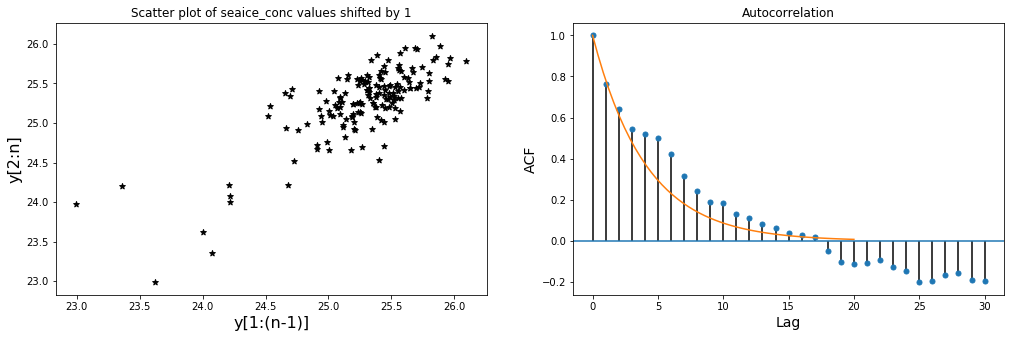

In [24]:
fig, ax = plt.subplots(1,2,figsize=(17,5))            # Set up figure and subplots
ax[0].scatter(y[:-1],y[1:],color='k',marker='*')      # scatter plot of values shifted by 1
ax[0].set_xlabel('y[1:(n-1)]',fontsize=16)            # x axis label
ax[0].set_ylabel('y[2:n]',fontsize=16)                # y axis label
ax[0].set_title('Scatter plot of seaice_conc values shifted by 1')
sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[1]) # plot empirical autocorrelation function
alpha_hat = np.corrcoef(y[:-1],y[1:])[0,1]           # the correlation coefficient between lagged values
ax[1].plot(np.linspace(0,20),alpha_hat**np.linspace(0,20))        # line for theoretical acf using correlation coeff
ax[1].set_xlabel('Lag', fontsize=14)                  # x axis label
ax[1].set_ylabel('ACF',fontsize=14)                   # y axis label
#sm.graphics.tsa.plot_acf(y,lags=30,alpha=np.float('nan'),ax=ax[2]) # plot empirical autocorrelation function
#ax[2].plot(np.linspace(0,20),0.7662343**np.linspace(0,20)) # plot optimized autocorrelation function (more info below)
#ax[2].set_xlabel('Lag', fontsize=14)                  # x axis label
#ax[2].set_ylabel('ACF',fontsize=14)                   # y axis label
plt.show()
#plt.savefig('figs/autoregressive.png')

In [25]:
# Fit a linear regression between y and time, specifying a first order autoregressive covariance matrix. 
# Specify method='ML' to fit exact maximum likelihood
print(r.summary(nlme.gls(r.formula("y ~ t1"), correlation=nlme.corAR1(),method='ML')))

Generalized least squares fit by maximum likelihood
  Model: y ~ t1 
  Data: NULL 
       AIC      BIC    logLik
  59.81062 72.21009 -25.90531

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7662343 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 32.43808  3.655355  8.874128  0.0000
t1          -0.00373  0.001892 -1.971625  0.0504

 Correlation: 
   (Intr)
t1 -1    

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-4.40980463 -0.35191840  0.05324723  0.53181699  2.38815117 

Residual standard error: 0.4398229 
Degrees of freedom: 164 total; 162 residual



### Harmonic regression

In [26]:
nyrs = t1.max() - t1.min() + 1
f = np.linspace(0, 2*np.pi*nyrs, len(y), dtype=np.float64)
sinf = np.sin(f)
cosf = np.cos(f)

In [27]:
robjs.globalenv["sinf"] = robjs.FloatVector(sinf) # Add sine to R envrionment as FloatVector
robjs.globalenv["cosf"] = robjs.FloatVector(cosf) # Add cose to R envrionment as FloatVector
#-- fit regression with seasonal component and first order autoregressive covariance matrix
print(r.summary(nlme.gls(r.formula("y ~ sinf + cosf"), correlation=nlme.corAR1(),method='ML')))

Generalized least squares fit by maximum likelihood
  Model: y ~ sinf + cosf 
  Data: NULL 
       AIC      BIC    logLik
  64.35065 79.84999 -27.17533

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.7916349 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 25.236001 0.1055274 239.14161  0.0000
sinf         0.028011 0.1507382   0.18582  0.8528
cosf        -0.136508 0.1438820  -0.94875  0.3442

 Correlation: 
     (Intr) sinf  
sinf  0.000       
cosf -0.068  0.000

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-4.5169326 -0.3833876  0.2399163  0.6819041  2.0077035 

Residual standard error: 0.465999 
Degrees of freedom: 164 total; 161 residual



## Time series decomposition

In [28]:
fit = nlme.gls(r.formula('y ~ sinf + cosf + t1'), correlation=nlme.corAR1(), method='ML')

In [29]:
print(r.summary(fit))

Generalized least squares fit by maximum likelihood
  Model: y ~ sinf + cosf + t1 
  Data: NULL 
       AIC      BIC    logLik
  59.08643 77.68563 -23.54322

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
     Phi 
0.723617 

Coefficients:
               Value Std.Error   t-value p-value
(Intercept) 39.03511  4.553353  8.572829  0.0000
sinf        -0.33283  0.164774 -2.019891  0.0451
cosf        -0.12260  0.108425 -1.130770  0.2598
t1          -0.00714  0.002357 -3.029358  0.0029

 Correlation: 
     (Intr) sinf   cosf  
sinf -0.732              
cosf -0.001  0.000       
t1   -1.000  0.732  0.000

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-3.8765989 -0.4946197  0.1250875  0.6931627  2.3477637 

Residual standard error: 0.4037854 
Degrees of freedom: 164 total; 160 residual



In [30]:
k_hat = fit.rx2('coefficients')          # extract fitted regression coefficients
print(k_hat)                              # Display for comparison with R
k_hat_var = np.array(fit.rx2('varBeta')) # extract the associated errors
print(k_hat_var)                          # Display for comparison with R
phi_hat = stats.coef(fit.rx2("modelStruct"),unconstrained=False) #extract fitted autoregressive parameter
e = np.array(fit.rx2('residuals'))       #extract 'raw' residuals (yi - ypred) 

 (Intercept)         sinf         cosf           t1 
39.035113404 -0.332826440 -0.122603644 -0.007140399 

[[  2.07330197e+01  -5.48975303e-01  -4.33205791e-04  -1.07309580e-02]
 [ -5.48975303e-01   2.71506225e-02   7.77701552e-16   2.84222264e-04]
 [ -4.33205791e-04   7.77701552e-16   1.17559677e-02   1.43198920e-17]
 [ -1.07309580e-02   2.84222264e-04   1.43198920e-17   5.55576392e-06]]


In [36]:
phi_hat

R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x7efdd4320ec8 / R:0x5c7c6b8>
[0.723617]

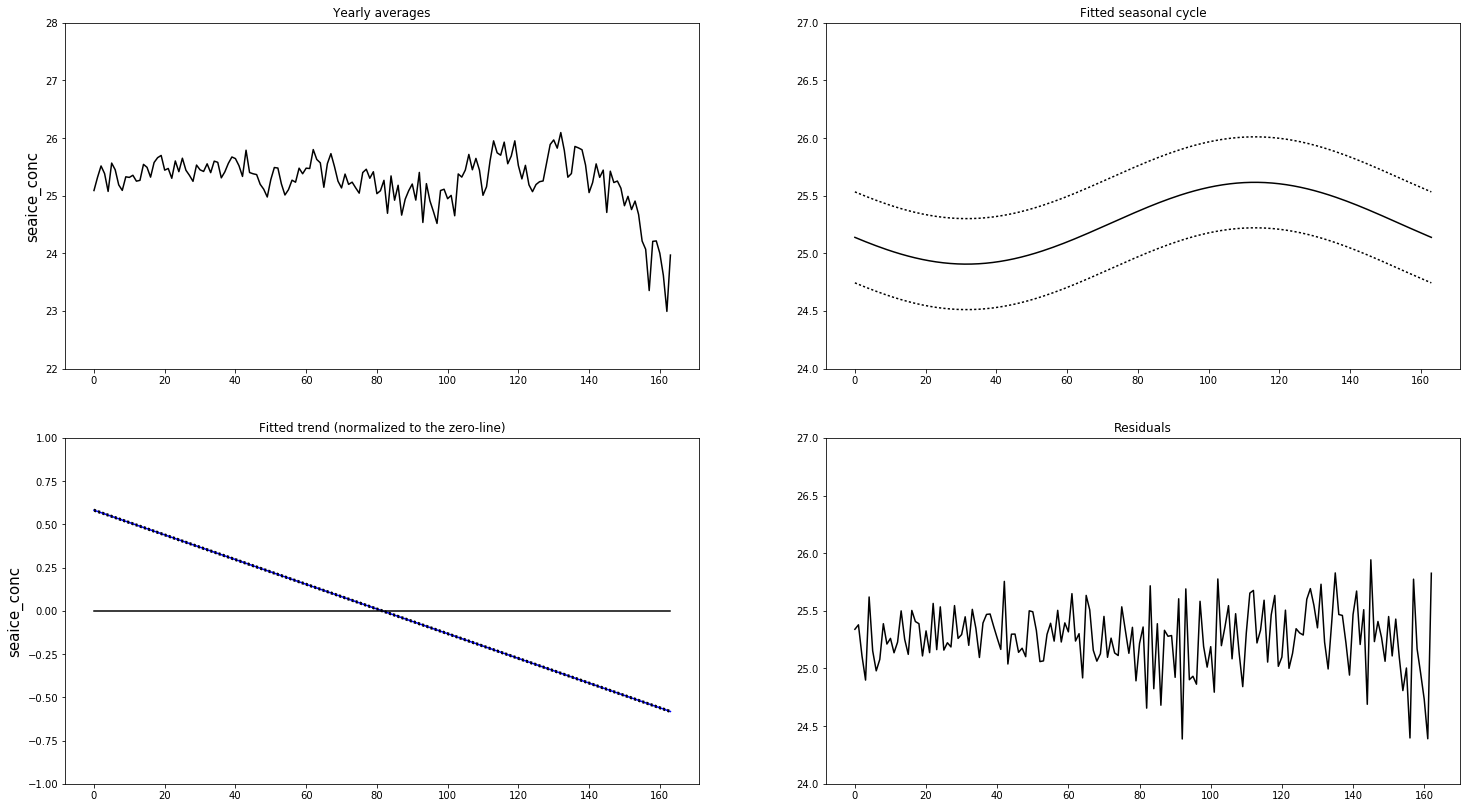

In [24]:
#-- Plot results
fig, ax = plt.subplots(2,2,figsize=(25,14))    # set up figure and panels
ax[0,0].plot(y,'k-')                         # plot the data
ax[0,0].set_ylim([22,28])                    # y axis range
ax[0,0].set_ylabel('seaice_conc',fontsize=15) # y axis label
ax[0,0].set_title('Yearly averages')

f_hat = np.mean(y) + k_hat[1]*sinf + k_hat[2]*cosf  # fitted seasonal cycle
ax[0,1].plot(f_hat,'k-')                             # plot fitted seasonal cycle
#-- add 95% CIs (upper and lower); note the variance is already std^2
ax[0,1].plot(f_hat + 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:') 
ax[0,1].plot(f_hat - 2*np.sqrt(k_hat_var[1,1] + k_hat_var[2,2]),'k:')
ax[0,1].set_ylim([24,27])                           # y axis range
ax[0,1].set_title('Fitted seasonal cycle')

t_hat = k_hat[0] + k_hat[3]*t1                       # fitted trend
t_hat -= np.mean(t_hat)                              # normalize to the zero-line
ax[1,0].plot(t_hat,'b-')                             # plot fitted trend
ax[1,0].plot(t_hat + 2*np.sqrt(k_hat_var[3,3]),'k:') # upper 95% CI
ax[1,0].plot(t_hat - 2*np.sqrt(k_hat_var[3,3]),'k:') # lower  95% CI
ax[1,0].plot(np.zeros(len(t_hat)),'k-')              # add 0 line 
ax[1,0].set_ylabel('seaice_conc',fontsize=15)        # y axis label
ax[1,0].set_ylim([-1,1])                     # y axis range
ax[1,0].set_title('Fitted trend (normalized to the zero-line)')

ear = e[1:]-phi_hat*e[:-1]                    # subtract the autoregression
ax[1,1].plot(np.mean(y)+ear,'k-')            # plot the residuals
ax[1,1].set_ylim([24,27])                  # y axis range
ax[1,1].set_title('Residuals')
#plt.show()
plt.savefig('figs/timeseries_decomp.png')

In [63]:
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')

In [64]:
seas_df = seasons.to_dataframe()

In [65]:
seas_df.head()

,season,seaice_conc
time,,
1850-01-15,DJF,27.489681
1850-02-15,DJF,27.736692
1850-03-15,MAM,28.199677
1850-04-15,MAM,27.986870
1850-05-15,MAM,27.220930


In [66]:
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

In [67]:
seas_df.head(n=12)

,level_0,season,seaice_conc
0,1850,DJF,27.071581
1,1850,JJA,22.740511
2,1850,MAM,27.802492
3,1850,SON,21.496429
4,1851,DJF,27.708511
5,1851,JJA,23.405035
6,1851,MAM,27.766169
7,1851,SON,21.515064
8,1852,DJF,27.508768
9,1852,JJA,23.959072


In [68]:
seas_df.rename(columns={'level_0': 'year'}, inplace=True)
seas_df.head(n=12)

,year,season,seaice_conc
0,1850,DJF,27.071581
1,1850,JJA,22.740511
2,1850,MAM,27.802492
3,1850,SON,21.496429
4,1851,DJF,27.708511
5,1851,JJA,23.405035
6,1851,MAM,27.766169
7,1851,SON,21.515064
8,1852,DJF,27.508768
9,1852,JJA,23.959072


In [69]:
djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

In [70]:
djf_df.head()

,year,season,seaice_conc
0,1850,DJF,27.071581
4,1851,DJF,27.708511
8,1852,DJF,27.508768
12,1853,DJF,27.586924
16,1854,DJF,27.599110


In [71]:
cmap = {'JJA': 'crimson', 'SON': 'darkorange', 'DJF': 'steelblue', 'MAM': 'seagreen'}

In [83]:
max(djf_df['seaice_conc'])

28.520395

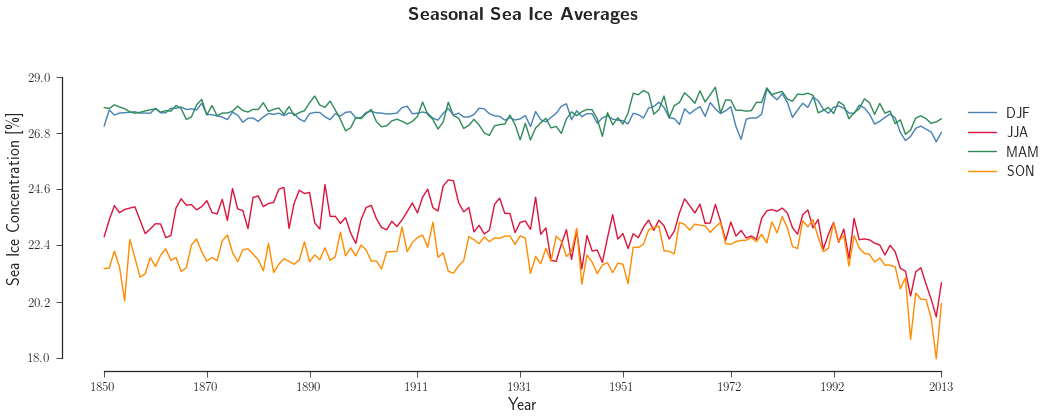

In [107]:
f, ax = plt.subplots(1, 1, figsize=(14,6))

sns.set_style("ticks")

ax.plot(djf_df.year, djf_df['seaice_conc'], color=cmap['DJF'], label='DJF')
ax.plot(jja_df.year, jja_df['seaice_conc'], color=cmap['JJA'], label='JJA')
ax.plot(mam_df.year, mam_df['seaice_conc'], color=cmap['MAM'], label='MAM')
ax.plot(son_df.year, son_df['seaice_conc'], color=cmap['SON'], label='SON')


ax.set_title(r'\textbf{Seasonal Sea Ice Averages}', fontsize=19)
ax.set_ylabel(r'Sea Ice Concentration [\%]', fontsize=17)
ax.set_xlabel(r'Year', fontsize=17)

ax.set_ylim(17.5, 31)

ax.legend(bbox_to_anchor=(.97,0.8), loc='upper left', fontsize=14)
#ax.legend(loc="upper left")

ax.set_xticks(np.linspace(1850, 2013, 9, dtype=int))
ax.set_yticks(np.linspace(18, 29, 6))
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
sns.despine(trim=True)
f.tight_layout()


f.savefig('writeup/figs/seasonal_avgs.eps', format='eps', 
          dpi=1200, bbox_inches='tight')

In [33]:
djf = go.Scatter(
    x = djf_df.year,
    y = djf_df['seaice_conc'],
    name = 'DJF Seaice Conc',
    opacity = 0.8)

jja = go.Scatter(
    x = jja_df.year,
    y = jja_df['seaice_conc'],
    name = 'JJA Seaice Conc',
    opacity = 0.8)

mam = go.Scatter(
    x = mam_df.year,
    y = mam_df['seaice_conc'],
    name = 'MAM Seaice Conc',
    opacity = 0.8)

son = go.Scatter(
    x = son_df.year,
    y = son_df['seaice_conc'],
    name = 'SON Seaice Conc',
    opacity = 0.8)

data = [djf, jja, mam, son]

layout = dict(
    title='Yearly Seasonal Seaice Averages',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=5,
                     label='5yr',
                     step='year',
                     stepmode='backward'),
                dict(count=10,
                     label='10yr',
                     step='year',
                     stepmode='backward'),
                dict(count=25,
                     label='25yr',
                     step='year',
                     stepmode='backward'),
                dict(count=50,
                     label='50yr',
                     step='year',
                     stepmode='backward'),
                dict(count=100,
                     label='100yr',
                     step='year',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

In [34]:
fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Seasonal Seaice Averages")

In [35]:
y2 = djf_df['seaice_conc'].values
t2 = djf_df.year.values

robjs.globalenv['y2'] = robjs.FloatVector(y2)
robjs.globalenv['t2'] = robjs.FloatVector(t2)

In [36]:
fit = r.lm('y2 ~ t2')
print(str(r.summary(fit))[str(r.summary(fit)).find('Residuals:'):])

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00509 -0.13767  0.00765  0.14679  1.02883 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 29.0531243  0.9762888  29.759   <2e-16 ***
t2          -0.0007891  0.0005053  -1.562     0.12    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3064 on 162 degrees of freedom
Multiple R-squared:  0.01483,	Adjusted R-squared:  0.008748 
F-statistic: 2.438 on 1 and 162 DF,  p-value: 0.1203




In [37]:
print(r.summary(nlme.gls(r.formula("y2 ~ t2"), correlation=nlme.corAR1(),method='ML')))

Generalized least squares fit by maximum likelihood
  Model: y2 ~ t2 
  Data: NULL 
        AIC      BIC   logLik
  -7.430793 4.968672 7.715397

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.6644519 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 29.131924 2.1246852 13.711172  0.0000
t2          -0.000837 0.0010997 -0.761064  0.4477

 Correlation: 
   (Intr)
t2 -1    

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-3.20282869 -0.40633575  0.06102749  0.51305802  3.38813102 

Residual standard error: 0.3083522 
Degrees of freedom: 164 total; 162 residual



In [38]:
def plot_contour_arctic(idx, title=None, save_path=None):  
    lat = nc.latitude.values
    lon = nc.longitude.values
    conc = nc.seaice_conc.values
    fig = plt.figure(figsize=(10, 10))
    
    levels = np.arange(0, 100, 10)

    lat_min = 30.0
    lat_max = 80.0
    lon_min = -180
    lon_max = 180

    m = Basemap(width=10.e6, height=11e6,
                projection='gnom', lat_0=88.0, lon_0=-30.0)

    x, y = m(*np.meshgrid(lon[:], lat[:]))
    m.drawcoastlines(color='black')
    m.fillcontinents(color='gray')

    m.drawmeridians(np.arange(np.min(lon), np.max(lon), 20),labels=[0,0,0,1])
    m.drawparallels(np.arange(lat_min, lat_max,10),labels=[1,0,0,0])

    CS1 = m.contourf(x,y,conc[idx,:,:],
                     levels,cmap=plt.get_cmap('RdYlBu_r',len(levels)-1),
                     extend='max')
    CS1.axis='tight'
    plt.colorbar(CS1,orientation='vertical',extend='max', shrink=0.5)

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3608: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/home/hflores/anaconda2/envs/arcticsea/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3677: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



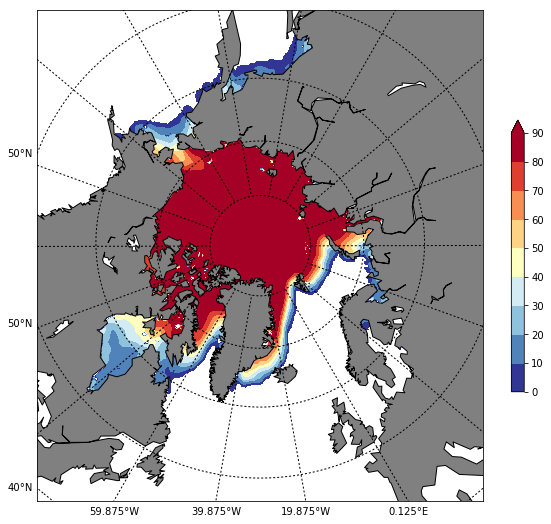

In [39]:
plot_contour_arctic(10)